In [1]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import PreProcessor as pp

In [2]:
dataset = pp.load_dataset("adl-piano-midi")
ClassicSongs = pp.files_to_songs(dataset["Classical"])

channel_to_ind, ind_to_channel, note_to_ind, ind_to_note = pp.dicts_from_songs(ClassicSongs)
velocity_range, tick_range = pp.ranges_from_songs(ClassicSongs)

n_Channels = len(channel_to_ind)
n_Notes = len(note_to_ind)

print("Number of channels  :",n_Channels,"\nNumber of notes     :",n_Notes,"\nVelocity range      :",velocity_range[0],velocity_range[1],"\nTime ticks range    :",tick_range[0],tick_range[1])

Couldn't load : adl-piano-midi\Classical\Classical\Alexander Borodin\Nocturne.mid
Couldn't load : adl-piano-midi\Classical\Classical\Antonio Salieri\Invention.mid
Couldn't load : adl-piano-midi\Classical\Classical\Bela Bartok\Andante.mid
Couldn't load : adl-piano-midi\Classical\Classical\Bela Bartok\Romanian Folk Dance.mid
Couldn't load : adl-piano-midi\Classical\Classical\Claude Debussy\Clair De Lune.mid
Couldn't load : adl-piano-midi\Classical\Classical\Franz Schubert\Impromptu in C-Moll.mid
Couldn't load : adl-piano-midi\Classical\Classical\Franz Schubert\Impromptu in Ges-dur.mid
Couldn't load : adl-piano-midi\Classical\Classical\Franz Schubert\Trois Marches militaires 3.mid
Couldn't load : adl-piano-midi\Classical\Classical\Frederic Chopin\Prelude Op 28 No7.mid
Couldn't load : adl-piano-midi\Classical\Classical\Giacomo Puccini\O Mio Babibino Caro.mid
Couldn't load : adl-piano-midi\Classical\Classical\Jean-Baptiste Lully\Minuet.mid
Couldn't load : adl-piano-midi\Classical\Classical\

In [3]:
AllChannels = np.array([])
AllNotes = np.array([])
AllVelocities = np.array([])
AllTicks = np.array([])
for song in ClassicSongs.values():
    AllChannels = np.append(AllChannels,song[:,0])
    AllNotes = np.append(AllNotes,song[:,1])
    AllVelocities = np.append(AllVelocities,song[:,2])
    AllTicks = np.append(AllTicks,song[:,3])

OneHotChannels = pp.one_hot_encode(channel_to_ind,AllChannels)
OneHotNotes = pp.one_hot_encode(note_to_ind,AllNotes)
AllVelocities = AllVelocities.reshape((-1,1))
AllTicks = AllTicks.reshape((-1,1))

In [22]:
seq_length = 30
n_batch = 200

X_channels, y_channels = pp.label_sequences(OneHotChannels,seq_length,n_batch)
X_notes, y_notes = pp.label_sequences(OneHotNotes,seq_length,n_batch)
X_velocities, y_velocities = pp.label_sequences(AllVelocities,seq_length,n_batch)
X_ticks, y_ticks = pp.label_sequences(AllTicks,seq_length,n_batch)
print(X_channels.shape)
print(X_notes.shape)
print(X_velocities.shape)
print(X_ticks.shape)

#X_train = np.concatenate([X_notes, X_velocities], axis=2) #np.concatenate([X_channels, X_notes, X_velocities, X_ticks], axis=2)
#y_train = np.concatenate([y_notes, y_velocities], axis=2) #np.concatenate([y_channels, y_notes, y_velocities, y_ticks], axis=2)
#print(X_train.shape)
#print(y_train.shape)

(71600, 30, 12)
(71600, 30, 105)
(71600, 30, 1)
(71600, 30, 1)


In [23]:
from keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Lambda, Softmax, Activation, concatenate
from keras import optimizers
import tensorflow as tf

In [73]:
dim = 300

loss = []
channels_accuracy = []
notes_accuracy = []
velocities_accuracy = []
ticks_accuracy = []

# Define input layers for notes and velocities
input_channels = Input(shape=(None, n_Channels))
input_notes = Input(shape=(None, n_Notes))
input_velocities = Input(shape=(None, 1))
input_ticks = Input(shape=(None, 1))

# Define SimpleRNN layer
rnn_output = SimpleRNN(units=dim, return_sequences=True)(concatenate([input_channels, input_notes, input_velocities, input_ticks]))

# Define Dense layer for each branch
channels_output = Dense(units=n_Channels)(rnn_output)
notes_output = Dense(units=n_Notes)(rnn_output)
velocities_output = Dense(units=1)(rnn_output)
ticks_output = Dense(units=1)(rnn_output)

# Use Lambda layer to split the output of SimpleRNN into two branches
final_channels = Softmax(name="Channels")(channels_output)
final_notes = Softmax(name="Notes")(notes_output)
final_velocities = Lambda(lambda x: (tf.sigmoid(x) * (velocity_range[1] - velocity_range[0]) + velocity_range[0]), name="Velocities")(velocities_output)
final_ticks = Lambda(lambda x: (tf.sigmoid(x) * (tick_range[1] - tick_range[0]) + tick_range[0]), name="Time-Ticks")(ticks_output)

# Define the model with inputs and outputs
model = Model(inputs=[input_channels, input_notes, input_velocities, input_ticks], outputs=[final_channels, final_notes, final_velocities, final_ticks])

model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_85 (InputLayer)          [(None, None, 12)]   0           []                               
                                                                                                  
 input_86 (InputLayer)          [(None, None, 105)]  0           []                               
                                                                                                  
 input_87 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                                  
 input_88 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                           

In [76]:
n_epochs = 20

def rounded_accuracy(y_true, y_pred):
    y_pred_rounded = tf.round(y_pred)
    correct_predictions = tf.equal(tf.cast(y_pred_rounded, tf.int32), tf.cast(y_true, tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

losses = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'mean_squared_error',
    'Time-Ticks': 'mean_squared_error'
}


loss_weights = {
    'Channels': 0.5,
    'Notes': 5.0,
    'Velocities': 0.02,
    'Time-Ticks': 2e-7
}

metrics = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': rounded_accuracy,
    'Time-Ticks': rounded_accuracy
}

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)
history = model.fit([X_channels, X_notes, X_velocities, X_ticks], [y_channels, y_notes, y_velocities, y_ticks], epochs=n_epochs, batch_size=n_batch)

loss.append(history.history['loss'])
channels_accuracy.append(history.history['Channels_accuracy'])
notes_accuracy.append(history.history['Notes_accuracy'])
velocities_accuracy.append(history.history['Velocities_rounded_accuracy'])
ticks_accuracy.append(history.history['Time-Ticks_rounded_accuracy'])

358/358 [==============================] - 70s 189ms/step - loss: 36.0001 - Channels_loss: 0.7033 - Notes_loss: 3.9063 - Velocities_loss: 805.5319 - Time-Ticks_loss: 32771.7383 - Channels_accuracy: 0.6998 - Notes_accuracy: 0.0445 - Velocities_rounded_accuracy: 0.0085 - Time-Ticks_rounded_accuracy: 0.2241


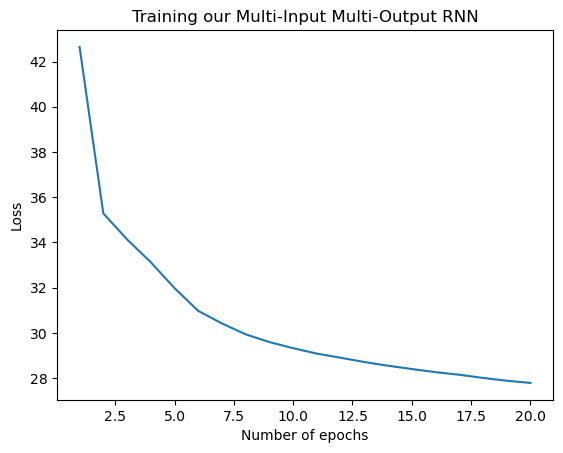

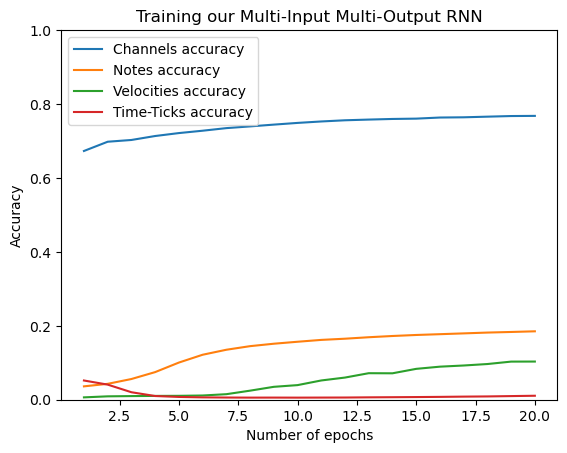

In [64]:
x = range(1,len(loss)+1)
plt.figure()
plt.plot(x, loss)
plt.title("Training our Multi-Input Multi-Output RNN")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.xticks(x)
plt.show()
plt.figure()
plt.plot(x, channels_accuracy, label="Channels accuracy")
plt.plot(x, notes_accuracy, label="Notes accuracy")
plt.plot(x, velocities_accuracy, label="Velocities accuracy")
plt.plot(x, ticks_accuracy, label="Time-Ticks accuracy")
plt.legend()
plt.ylim([0,1])
plt.title("Training our Multi-Input Multi-Output RNN")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.xticks(x)
plt.show()